# Keras TFboy 3D ConvNet

计划步骤

### 预处理

按照 full preprocessing.ipynb 的 resample 方法来做, 

每组 scan 按照 `1mm * 1mm * 1mm`, `1.5mm * 1.5mm * 1.5mm`, `3mm * 3mm * 3mm` 采样

先试 1.5mm, 不行就拿 3mm, 尽量不碰 1mm

完后每个 scan obj 存成 `*.npy`

每个 3dimage 的 shape 是不一样的, 如果是 1.5mm resample, 每个轴大约在 180~280 个数据

需要全补充到一个固定的 shape, 或者裁切掉外侧空气的部分


### Conv Net

按照 first pass through.ipynb 的方式来

但不直接使用 tf, 改用 keras 

网络参数抄 first pass through.ipynb 的

```
X - Conv3D(3,3,3, 32) - RELU - Pool3D
  - Conv3D(3,3,3, 64) - RELU - Pool3D
  - Flatten
  - FC(54080,1024) - RELU - Dropout
  - FC(1024, 2) - Softmax?
```

参数太多, 内存超了, 主要是 Flatten 那一步有巨大数量参数

最后也许不应该用 softmax

In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)


<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
import random
def random_hue(s=100, l=80):
  return 'hsl({}, {}%, {}%)'.format(random.randint(0, 360), s, l)

color1 = random_hue(s=20, l=95)
color2 = random_hue(s=40, l=80)
css = '''
<style>
div.cell {{background-color: {color1};}}
div.running {{background-color: {color2};}}
div.running.selected {{background-color: {color2};}}
</style>'''.format(color1=color1, color2=color2)

display(HTML(css))

In [3]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
# Some constants 
INPUT_FOLDER = 'ct_sample_images/'
patients = os.listdir(INPUT_FOLDER)
if '.DS_Store' in patients:
  patients.remove('.DS_Store')
patients.sort()

print(patients)

['00cba091fa4ad62cc3200a657aeb957e', '0a099f2549429d29b32f349e95fb2244', '0a0c32c9e08cc2ea76a71649de56be6d', '0a38e7597ca26f9374f8ea2770ba870d', '0acbebb8d463b4b9ca88cf38431aac69', '0b20184e0cd497028bdd155d9fb42dc9', '0bd0e3056cbf23a1cb7f0f0b18446068', '0c0de3749d4fe175b7a5098b060982a1', '0c37613214faddf8701ca41e6d43f56e', '0c59313f52304e25d5a7dcf9877633b1', '0c60f4b87afcb3e2dfa65abbbf3ef2f9', '0c98fcb55e3f36d0c2b6507f62f4c5f1', '0c9d8314f9c69840e25febabb1229fa4', '0ca943d821204ceb089510f836a367fd', '0d06d764d3c07572074d468b4cff954f', '0d19f1c627df49eb223771c28548350e', '0d2fcf787026fece4e57be167d079383', '0d941a3ad6c889ac451caf89c46cb92a', '0ddeb08e9c97227853422bd71a2a695e', '0de72529c30fe642bc60dcb75c87f6bd']


## 常用函数

In [50]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path)]
    # InvalidDicomError: File is missing 'DICM' marker. Use force=True to force reading
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices



def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # value * slope + intercept 之后才是 HU 值
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)
  


def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    # 需要保存计算后的 spacing, 由于 round 原因, 与提供的 spacing 将有微小的差异
    # 单位 毫米
    # 那么resample的方法应该非常重要, 
    # 需要研究 `scipy.ndimage.interpolation.zoom(image, real_resize_factor)` 有没有其他可能的处理方法
    # 重采样非常慢, [0.3,0.3,0.3] 就受不了了
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing


def image_save(image, filename):
  if not filename.endswith('.npy'):
    filename += '.npy'
  np.save(filename, image)
  return filename

def image_load(filename):  
  return np.load(filename)
  

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

    
    
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

      
      
def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image





def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image
  
  

def zero_center(image):
    PIXEL_MEAN = 0.25
    image = image - PIXEL_MEAN
    return image


  
def threshold_and_normalize(scan):
    scan = scan.astype(np.float32)
    scan [scan < THRESHOLD_LOW] = THRESHOLD_LOW
    scan [scan > THRESHOLD_HIGH] = THRESHOLD_HIGH
    # Maximum absolute value of any pixel .
    max_abs = abs (max(THRESHOLD_LOW, THRESHOLD_HIGH, key=abs))
    # This will bring values between -1 and 1
    scan /= max_abs
    return scan

  
  
def all_files(root, patterns='*', single_level=False, yield_folders=False):
  ''' 取得文件夹下所有文件
  single_level 仅处理 root 中的文件(文件夹) 不处理下层文件夹
  yield_folders 也遍历文件夹'''
  import fnmatch
  patterns = patterns.split(';')
  for path, subdirs, files in os.walk(root):
    if yield_folders:
      files.extend(subdirs)
    files.sort()
    for name in files:
      for pattern in patterns:
        if fnmatch.fnmatch(name, pattern):
          yield os.path.join(path, name)
          break
    if single_level:
      break



def datalines(data, sample=None):
  '''返回一段文字中有效的行(非空行, 且不以注释符号开头)'''
  ret = []
  for l in data.splitlines():
    line = l.strip()
    if line and not line.startswith('#'):
      ret.append(line)
  if sample:
    return ret[:sample]
  else:
    return ret
  
  
  

def load_csv(path, sample=10, only_title=False, include=(), exclude=()):
  from itertools import compress
  import csv

  with open(path) as f:
    titles = f.readline().strip().split(',')

  if include:
    column_compress = [_start_or_end_with(title, include) for title in titles]
  else:
    column_compress = [True] * len(titles)
  if exclude:
    column_compress = [not _start_or_end_with(title, exclude) and tb for title, tb in zip(titles, column_compress)]

  if only_title:
    return list(compress(titles, column_compress))

  with open(path) as f:
    lines = csv.reader(f)
    next(lines)
    result = []
    for i, line in enumerate(lines, 1):
      if sample and i > sample:
        break
      # result.append([_load_csv_value_convert(x) for x in compress(line, column_compress)])
      result.append([x for x in compress(line, column_compress)])

  return result

  
  

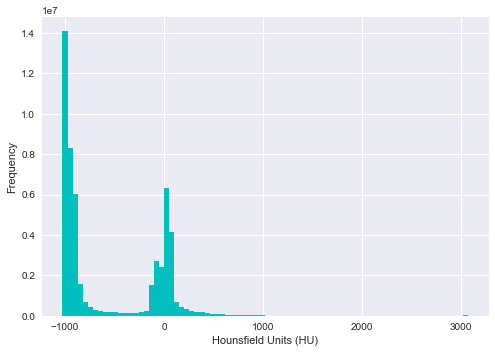

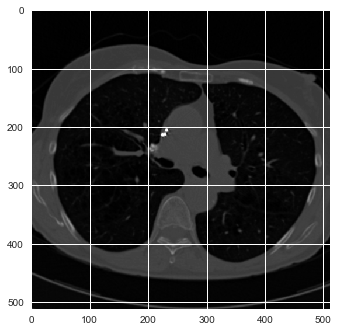

Shape before resampling	 (203, 512, 512)
Shape after resampling	 (244, 186, 186)
[ 1.49754098  1.5         1.5       ]


In [6]:
first_patient = load_scan(INPUT_FOLDER + patients[4])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()


# pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1, 1, 1])
# 1mm*1mm*1mm 之后在 plot_3d 时太慢了, 改粗略些
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1.5, 1.5, 1.5])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

print(spacing)

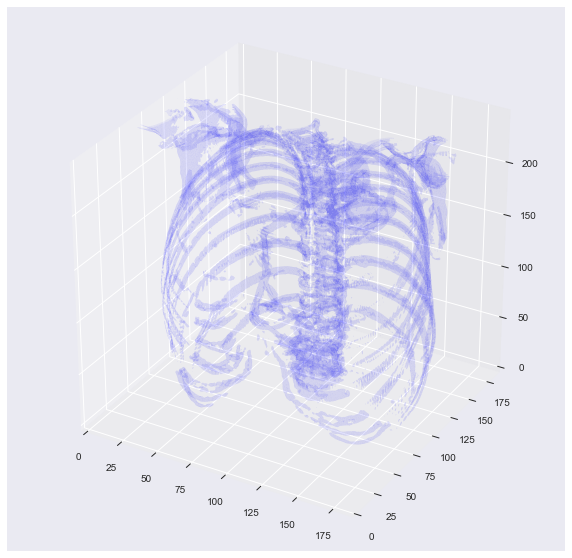

In [10]:
plot_3d(pix_resampled, 400)
segmented_lungs = segment_lung_mask(pix_resampled, fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, fill_lung_structures=True)

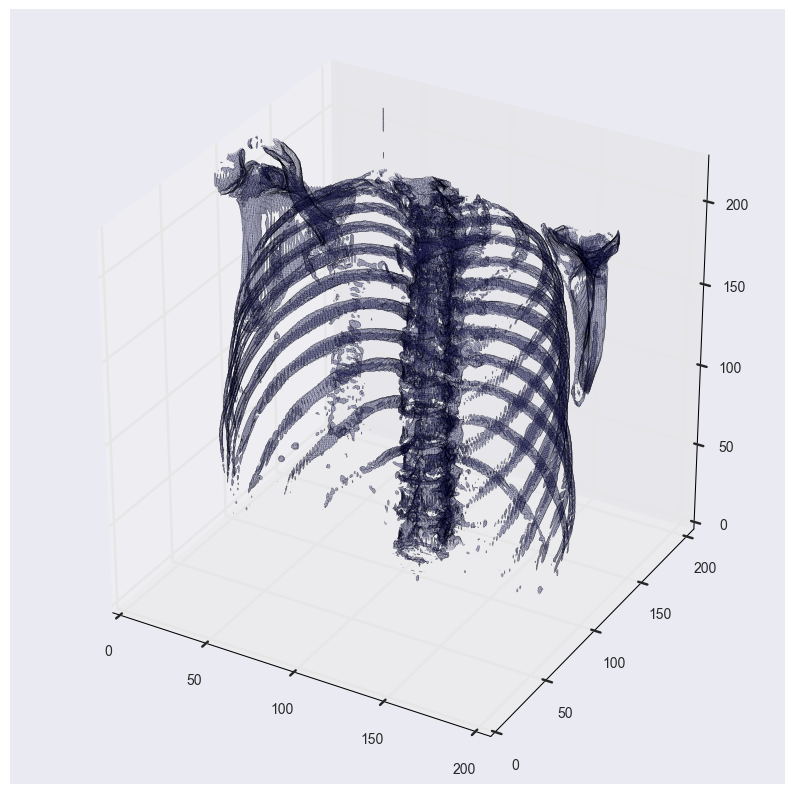

segmented_lungs
segmented_lungs_fill
segmented_lungs_fill - segmented_lungs


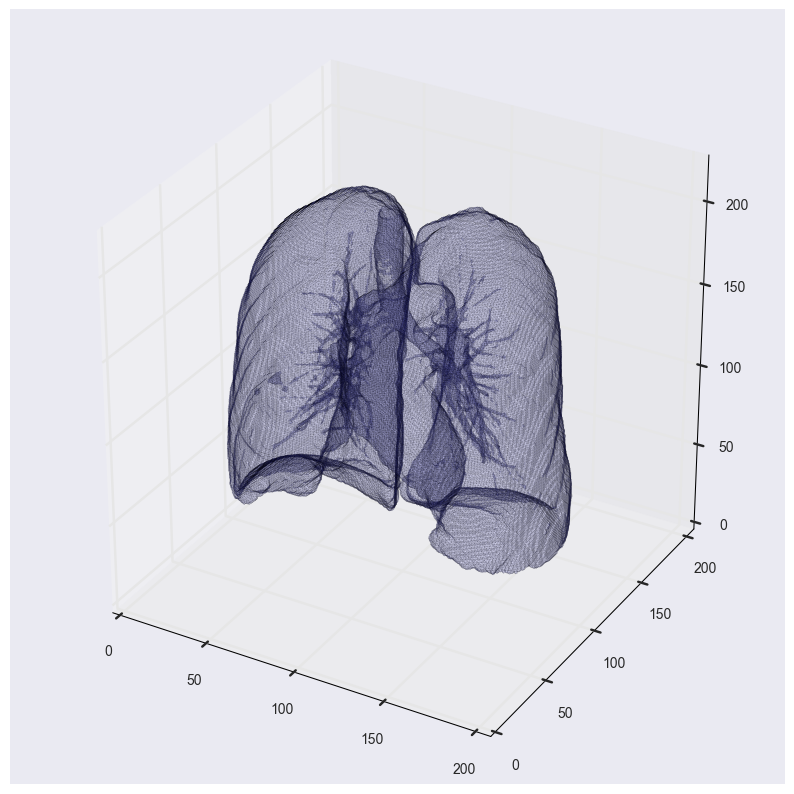

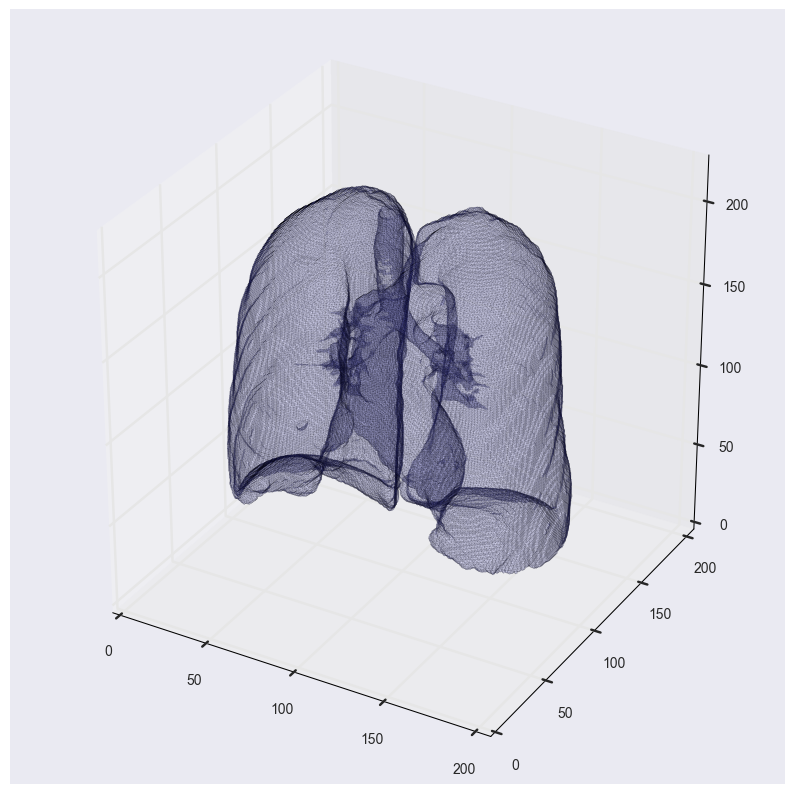

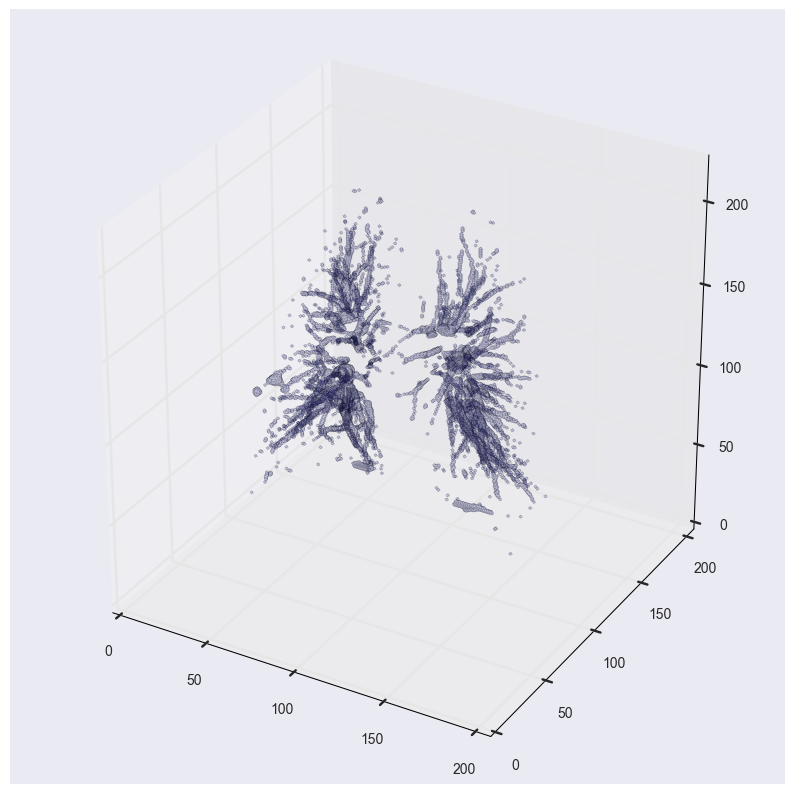

In [10]:
print("segmented_lungs")
plot_3d(segmented_lungs, 0)
print("segmented_lungs_fill")
plot_3d(segmented_lungs_fill, 0)
print("segmented_lungs_fill - segmented_lungs")
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [7]:
from dicom.errors import InvalidDicomError

def preprocess_scan(prefix, patient_folder, resample_size=(1.5, 1.5, 1.5), output_folder=None):
    # 存储预处理结果
    output_folder = output_folder or prefix
    scan = load_scan(prefix + patient_folder)  
    scan_pixels = get_pixels_hu(scan)
    pix_resampled, spacing = resample(scan_pixels, scan, list(resample_size))
    print("Shape before resampling\t", scan_pixels.shape)
    print("Shape after resampling\t", pix_resampled.shape)
    # print(spacing)
    filename = dump_image(pix_resampled, output_folder + patient_folder)
    data = {'spacing': [float(n) for n in spacing], 
            'shape': pix_resampled.shape,
            'shape_before_resampled': scan_pixels.shape,
            'resample_size': resample_size,
           }
    yaml_save(data, output_folder + patient_folder)
    print('dump_image done {} \n'.format(patient_folder))

    return filename, pix_resampled.shape, spacing

In [8]:

import yaml
from collections import OrderedDict
class IncludeOrderedLoader(yaml.Loader):
  ''' yaml loader
      以有序 dict 替代默认 dict
      值为 !include 开头时, 嵌套另一个 yaml

        -- main.yaml
        key_normal: [foo, bar]
        key_included: !include 'another.yaml'

        -- another.yaml
        foo: bar
        bar: baz

        -- nested result
        key_normal: [foo, bar]
        key_included:
          foo: bar
          bar: baz

      !include 可以是绝对路径或相对路径
      如果嵌套太深, 可能遇到相对路径错乱的问题
  '''
  def __init__(self, stream):
    super(IncludeOrderedLoader, self).__init__(stream)
    self.add_constructor(yaml.resolver.BaseResolver.DEFAULT_MAPPING_TAG,
                         self._construct_mapping)
    self.add_constructor('!include', self._include)
    self._root = os.path.split(stream.name)[0]

  def _include(self, loader, node):
    filename = os.path.join(self._root, self.construct_scalar(node))
    return yaml.load(encode_open(filename), IncludeOrderedLoader)

  def _construct_mapping(self, loader, node):
    loader.flatten_mapping(node)
    return OrderedDict(loader.construct_pairs(node))


def yaml_load(stream, loader=IncludeOrderedLoader):
  ''' 按照有序字典载入yaml 支持 !include
      yaml_load(encode_open(path))
  '''
  return yaml.load(stream, loader)


def yaml_save(data, path):
  if not path.endswith('.yaml'):
    path += '.yaml'
  with open(path, 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)


# path = '00cba091fa4ad62cc3200a657aeb957e.yaml'
# yaml_load(open(path))

In [24]:
# debug InvalidDicomError
# File is missing 'DICM' marker. Use force=True to force reading
# InvalidDicomError 0c9d8314f9c69840e25febabb1229fa4
# File is missing 'DICM' marker. Use force=True to force reading
# InvalidDicomError 0d941a3ad6c889ac451caf89c46cb92a
# folder = '0c9d8314f9c69840e25febabb1229fa4'
# folder = '0d941a3ad6c889ac451caf89c46cb92a'
# filename, shape, spacing = preprocess_scan(prefix=INPUT_FOLDER, patient_folder=folder)

Shape before resampling	 (221, 512, 512)
Shape after resampling	 (265, 206, 206)
dump_image done 0c9d8314f9c69840e25febabb1229fa4 



In [18]:

output_filenames, shapes = [], []
for patient_folder in patients:
  try: 
    filename, shape, spacing = preprocess_scan(prefix=INPUT_FOLDER, 
                                               patient_folder=patient_folder)
  except InvalidDicomError as e:
    print(e)
    print("!! InvalidDicomError {}".format(patient_folder))
    continue
      
  output_filenames.append(filename)
  shapes.append(shape)


Shape before resampling	 (134, 512, 512)
Shape after resampling	 (223, 204, 204)
dump_image done 00cba091fa4ad62cc3200a657aeb957e 

Shape before resampling	 (128, 512, 512)
Shape after resampling	 (213, 231, 231)
dump_image done 0a099f2549429d29b32f349e95fb2244 

Shape before resampling	 (133, 512, 512)
Shape after resampling	 (222, 227, 227)
dump_image done 0a0c32c9e08cc2ea76a71649de56be6d 

Shape before resampling	 (110, 512, 512)
Shape after resampling	 (183, 213, 213)
dump_image done 0a38e7597ca26f9374f8ea2770ba870d 

Shape before resampling	 (203, 512, 512)
Shape after resampling	 (244, 186, 186)
dump_image done 0acbebb8d463b4b9ca88cf38431aac69 

Shape before resampling	 (196, 512, 512)
Shape after resampling	 (235, 240, 240)
dump_image done 0b20184e0cd497028bdd155d9fb42dc9 

Shape before resampling	 (280, 512, 512)
Shape after resampling	 (233, 227, 227)
dump_image done 0bd0e3056cbf23a1cb7f0f0b18446068 

Shape before resampling	 (123, 512, 512)
Shape after resampling	 (205, 237, 

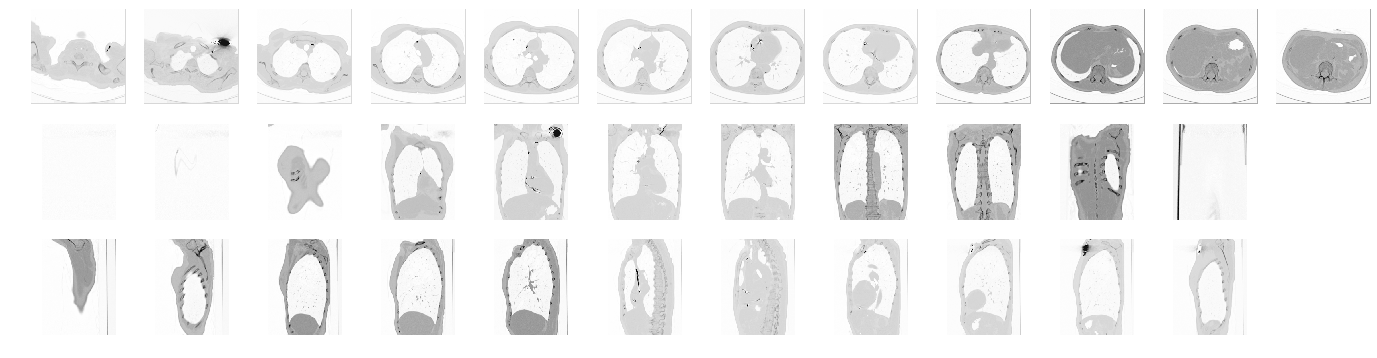

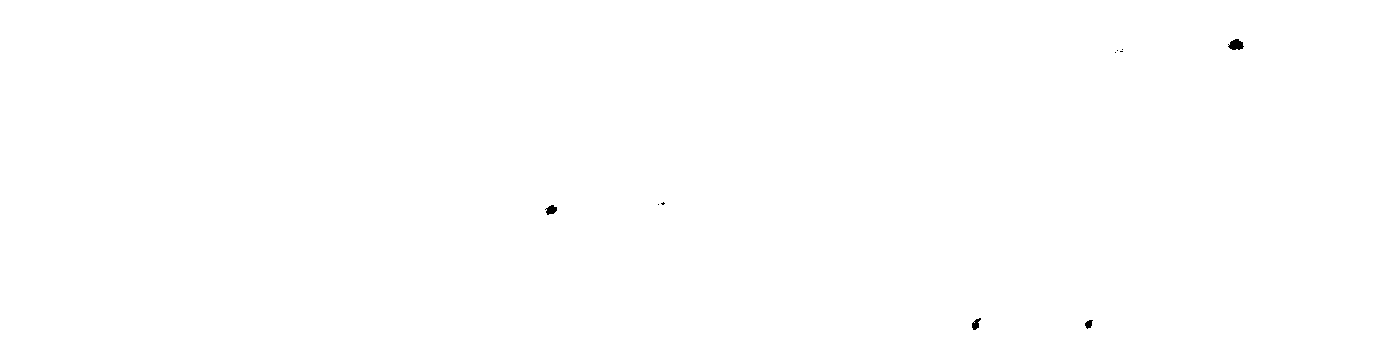

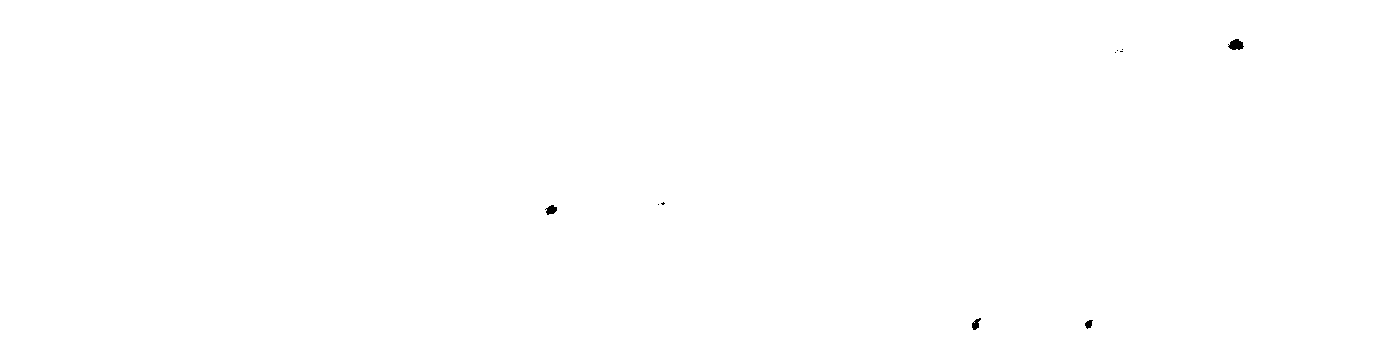

In [12]:
def list_sample(a, num=2):
  if num == 0:
    return []
  if num == 1:
    return a[:1]
  step = len(a) / (num-1)
  return [a[int(step*i)] for i in range(0, num-1)] + [a[-1]]

import cv2
def plot_2d_slices(image, label=None, slices=12):
  # image plot 为三行的 slice 图像, 均匀采样
  z, x, y = image.shape
  fig = plt.figure(figsize=(slices*2, 6))
  for plot_index, ix in enumerate(list_sample(list(range(z)), slices)):
    figsub = fig.add_subplot(3, slices, 0 * slices + plot_index + 1)
    each_slice = image[ix, :, :]
    figsub.axis('off')
    figsub.imshow(each_slice)

  for plot_index, ix in enumerate(list_sample(list(range(x)), slices)):
    figsub = fig.add_subplot(3, slices, 1 * slices + plot_index + 1)
    each_slice = image[:, ix, :]
    figsub.axis('off')
    figsub.imshow(each_slice)
    
  for plot_index, ix in enumerate(list_sample(list(range(y)), slices)):
    figsub = fig.add_subplot(3, slices, 2 * slices + plot_index + 1)
    each_slice = image[:, :, ix]
    figsub.axis('off')
    figsub.imshow(each_slice)

  plt.show()



plot_2d_slices(pix_resampled, slices=12)
plot_2d_slices(segmented_lungs, slices=12)
plot_2d_slices(segmented_lungs_fill, slices=12)

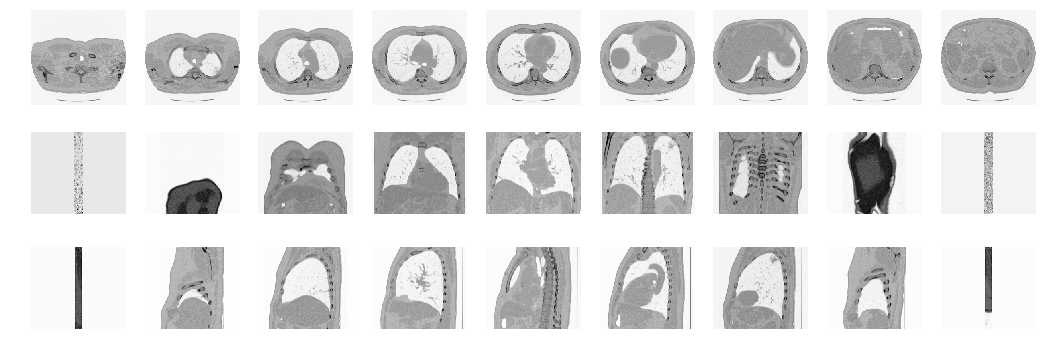

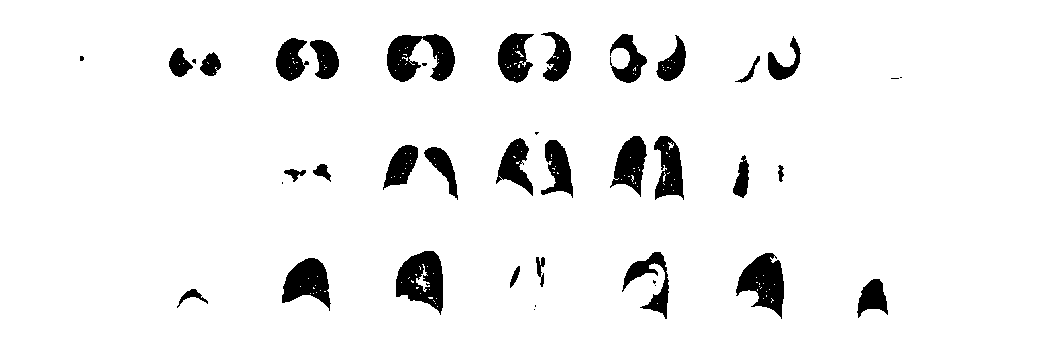

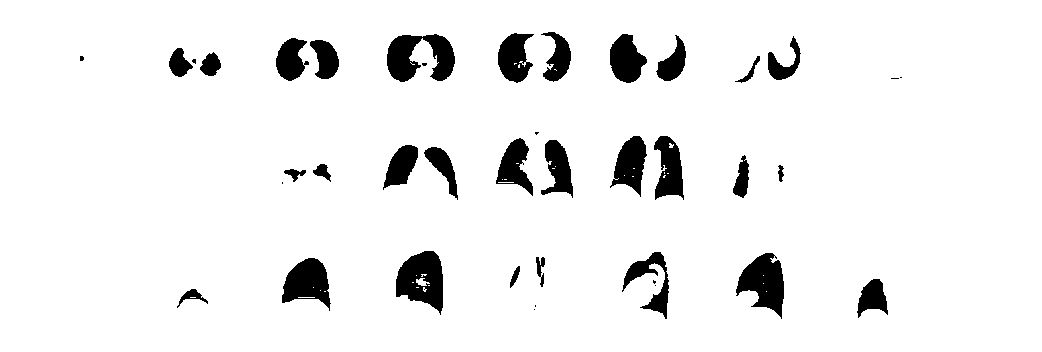

In [13]:


# plot_2d_slices(pix_resampled, slices=12)
# plot_2d_slices(segmented_lungs, slices=12)
# plot_2d_slices(segmented_lungs_fill, slices=12)

path = '0c0de3749d4fe175b7a5098b060982a1.npy'

image = load_image(path)
# print(image.shape)
plot_2d_slices(image, slices=9)

segmented_lungs = segment_lung_mask(image, fill_lung_structures=False)
plot_2d_slices(segmented_lungs, slices=9)
segmented_lungs_fill = segment_lung_mask(image, fill_lung_structures=True)
plot_2d_slices(segmented_lungs_fill, slices=9)

## Preprocess Stage1

In [34]:
# Some constants 
STAGE1_INPUT_FOLDER = 'D:/Dataset/lung_ct_stage1/'
STAGE1_OUTPUT_FOLDER = 'D:/Dataset/lung_ct_stage1_preprocess/'
stage1_patients = os.listdir(STAGE1_INPUT_FOLDER)
if '.DS_Store' in stage1_patients:
  stage1_patients.remove('.DS_Store')
stage1_patients.sort()

print("stage1 patients", len(stage1_patients), stage1_patients[:10])



# first 600 done
for patient_folder in stage1_patients[:600]:
  print(STAGE1_INPUT_FOLDER + patient_folder + '.npy')
  if os.path.exists(STAGE1_OUTPUT_FOLDER + patient_folder + '.npy') and os.path.exists(STAGE1_OUTPUT_FOLDER + patient_folder + '.yaml'):
#     print('--exists: ', patient_folder)
    continue
  try: 
    filename, shape, spacing = preprocess_scan(prefix=STAGE1_INPUT_FOLDER, 
                                               patient_folder=patient_folder, 
                                               output_folder=STAGE1_OUTPUT_FOLDER)
  except InvalidDicomError as e:
    print(e)
    print("!! InvalidDicomError {}".format(patient_folder))
    continue

#   output_filenames.append(filename)
#   shapes.append(shape)


stage1 patients 1595 ['0015ceb851d7251b8f399e39779d1e7d', '0030a160d58723ff36d73f41b170ec21', '003f41c78e6acfa92430a057ac0b306e', '006b96310a37b36cccb2ab48d10b49a3', '008464bb8521d09a42985dd8add3d0d2', '0092c13f9e00a3717fdc940641f00015', '00986bebc45e12038ef0ce3e9962b51a', '00cba091fa4ad62cc3200a657aeb957e', '00edff4f51a893d80dae2d42a7f45ad1', '0121c2845f2b7df060945b072b2515d7']
D:/Dataset/lung_ct_stage1/0015ceb851d7251b8f399e39779d1e7d.npy
D:/Dataset/lung_ct_stage1/0030a160d58723ff36d73f41b170ec21.npy
D:/Dataset/lung_ct_stage1/003f41c78e6acfa92430a057ac0b306e.npy
D:/Dataset/lung_ct_stage1/006b96310a37b36cccb2ab48d10b49a3.npy
D:/Dataset/lung_ct_stage1/008464bb8521d09a42985dd8add3d0d2.npy
D:/Dataset/lung_ct_stage1/0092c13f9e00a3717fdc940641f00015.npy
D:/Dataset/lung_ct_stage1/00986bebc45e12038ef0ce3e9962b51a.npy
D:/Dataset/lung_ct_stage1/00cba091fa4ad62cc3200a657aeb957e.npy
D:/Dataset/lung_ct_stage1/00edff4f51a893d80dae2d42a7f45ad1.npy
D:/Dataset/lung_ct_stage1/0121c2845f2b7df060945b072

C:\ProgramData\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Shape before resampling	 (361, 512, 512)
Shape after resampling	 (241, 253, 253)
dump_image done 573a661e2d784f9385a3b78c9757ddad 

D:/Dataset/lung_ct_stage1/573e900142c9e6e7b32ed9e5ffd5584c.npy
Shape before resampling	 (232, 512, 512)
Shape after resampling	 (232, 267, 267)
dump_image done 573e900142c9e6e7b32ed9e5ffd5584c 

D:/Dataset/lung_ct_stage1/5765dc0dbc8c02a4c862563eac4950ef.npy
Shape before resampling	 (155, 512, 512)
Shape after resampling	 (186, 233, 233)
dump_image done 5765dc0dbc8c02a4c862563eac4950ef 

D:/Dataset/lung_ct_stage1/57822feb6186b788c4e1877123428454.npy
Shape before resampling	 (145, 512, 512)
Shape after resampling	 (242, 213, 213)
dump_image done 57822feb6186b788c4e1877123428454 

D:/Dataset/lung_ct_stage1/5782e6873c666529c6a66421acb043dc.npy
Shape before resampling	 (184, 512, 512)
Shape after resampling	 (221, 233, 233)
dump_image done 5782e6873c666529c6a66421acb043dc 

D:/Dataset/lung_ct_stage1/5791c42d317f34592be9a933c50e68ad.npy
Shape before resampling	 

600


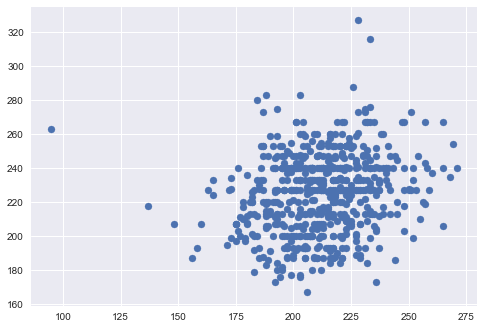

In [37]:
# preview shape

shapes = []

path = 'D:/Dataset/lung_ct_stage1_preprocess/'
for path in all_files(path, patterns='*.yaml', single_level=True):
  info = yaml_load(open(path))
  # print(info['shape'])
  shapes.append(info['shape'])  # z, x, y, and x==y
xs = [elem[0] for elem in shapes]
ys = [elem[1] for elem in shapes]

print(len(xs))
plt.scatter(xs, ys)

In [42]:
# pad to same shape

path = 'D:/Dataset/lung_ct_stage1_preprocess/024efb7a1e67dc820eb61cbdaa090166.npy'

image = image_load(path)
print('image', image.shape)


def pad_image_axis(image, value=-1024, axis='z', size=300):
  # shape z, x, y
  shape_index = ({'z': 0, 'x': 1, 'y': 2,}).get(axis)
  old_size = image.shape[shape_index]
  if size == old_size:
    return image
  if size < old_size:
    trim = old_size - size
    trim_before = trim // 2
    trim_after = trim - trim_before
    if axis == 'z': return image[trim_before:-trim_after, :, :]
    if axis == 'x': return image[:, trim_before:-trim_after, :]
    if axis == 'y': return image[:, :, trim_before:-trim_after]

  if size > old_size:
    pad = size - old_size
    pad_before = pad // 2
    pad_after = pad - pad_before
    if axis == 'z': pad_config = ((pad_before, pad_after), (0,0), (0,0))
    if axis == 'x': pad_config = ((0,0), (pad_before, pad_after), (0,0))
    if axis == 'y': pad_config = ((0,0), (0,0), (pad_before, pad_after))
    return np.pad(image, pad_width=pad_config, mode='constant', constant_values=value)

  
  
def pad_image(image, value=-1024, new_shape=(100, 100, 100)):
  image = pad_image_axis(image, value=value, axis='z', size=new_shape[0])
  image = pad_image_axis(image, value=value, axis='x', size=new_shape[1])
  image = pad_image_axis(image, value=value, axis='y', size=new_shape[2])
  return image
  
  
# image2 = pad_image_axis(image, value=-1025, axis='x', size=400)
# print('image2', image2.shape)
# plot_2d_slices(image, slices=9)
# plot_2d_slices(image2, slices=9)


  
# image2 = pad_image(image, value=1500, new_shape=(400, 300, 200))
# plot_2d_slices(image, slices=9)
# print('image2', image2.shape)
# plot_2d_slices(image2, slices=9)
# print(image2)

image (233, 316, 316)


## Build ConvNet

In [9]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2

Using TensorFlow backend.


In [100]:
model = Sequential()
L2reg = l2(0.01)
adam = keras.optimizers.Adam(lr=0.001, 
                             beta_1=0.9, beta_2=0.999, 
                             epsilon=1e-08, decay=0.88)

# Convolution3D(nb_filter, kernel_dim1, kernel_dim2, kernel_dim3, 
#               init='glorot_uniform', activation='linear', 
#               weights=None, border_mode='valid', subsample=(1, 1, 1), 
#               dim_ordering='th', W_regularizer=None, b_regularizer=None)

input_shape = (256, 256, 256, 1)

model.add(MaxPooling3D(input_shape=input_shape))
model.add(MaxPooling3D())
model.add(Convolution3D(32, 3, 3, 3, 
                        border_mode='same',
                        dim_ordering='tf',
                        # W_regularizer=L2reg,
                        ))
model.add(MaxPooling3D())
model.add(Activation('relu'))
model.add(Convolution3D(64, 3, 3, 3, 
                        border_mode='same',
                        dim_ordering='tf',
                        ))
model.add(MaxPooling3D())
model.add(Activation('relu'))

model.add(Convolution3D(128, 3, 3, 3, 
                        border_mode='same',
                        dim_ordering='tf',
                        ))
model.add(MaxPooling3D())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(500, W_regularizer=L2reg))
model.add(Activation('relu'))
model.add(Dense(300, W_regularizer=L2reg))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

# model.add(BatchNormalization())

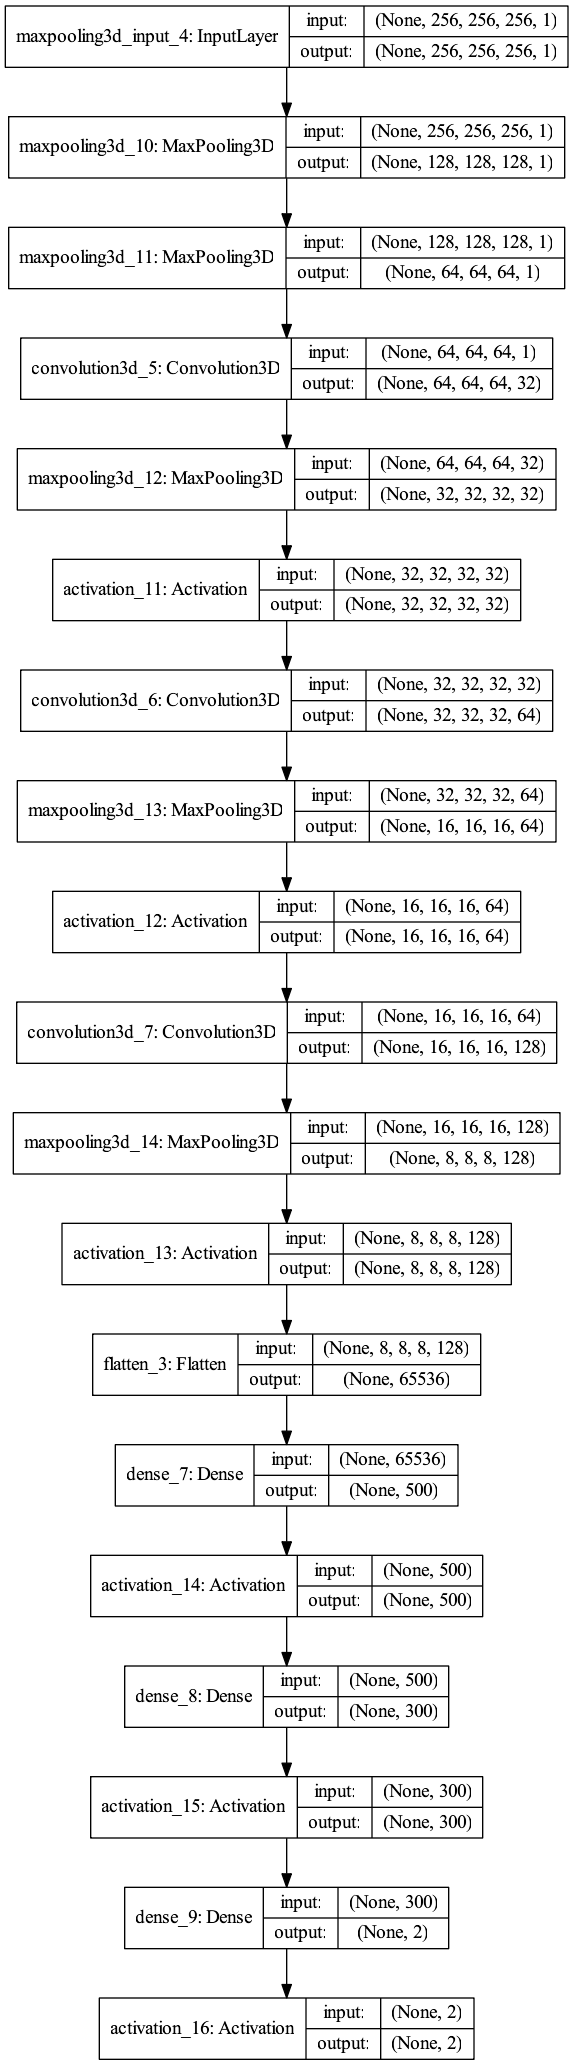

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling3d_10 (MaxPooling3D)   (None, 128, 128, 128, 0           maxpooling3d_input_4[0][0]       
____________________________________________________________________________________________________
maxpooling3d_11 (MaxPooling3D)   (None, 64, 64, 64, 1) 0           maxpooling3d_10[0][0]            
____________________________________________________________________________________________________
convolution3d_5 (Convolution3D)  (None, 64, 64, 64, 32 896         maxpooling3d_11[0][0]            
____________________________________________________________________________________________________
maxpooling3d_12 (MaxPooling3D)   (None, 32, 32, 32, 32 0           convolution3d_5[0][0]            
___________________________________________________________________________________________

In [101]:
from keras.utils.visualize_util import plot
plot(model, show_shapes=True, to_file='model.png')
from IPython.display import display, Image
display(Image('model.png', width=600))

print(model.to_yaml(), file=open('model.yaml', 'w'))
# %pycat model.yaml
print(model.summary())

filepath='model.h5'
# model.save_weights(filepath) # 将模型权重保存到指定路径，文件类型是HDF5（后缀是.h5）
# model.load_weights(filepath, by_name=False)

In [12]:
import platform
windows = platform.platform().startswith('Windows')

class BatchLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_loss = []
    def on_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss'))
batch_loss_history = BatchLossHistory()

In [103]:
adam_for_recompile = keras.optimizers.Adam(lr=0.00001, 
                                           beta_1=0.9, beta_2=0.999, 
                                           epsilon=1e-08, decay=0.88)
# try recompile

# from keras.utils.np_utils import to_categorical
# categorical_labels = to_categorical(int_labels, nb_classes=None)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




In [96]:
# prepare data

input_folder = 'C:/Coding/kaggle-dsb2017-lung-ct/ct_sample_images/'
preprocessed_folder = 'C:/Coding/kaggle-dsb2017-lung-ct/preprocessed/'



labels = load_csv('stage1_labels.csv', sample=None)
labels = {id: float(cancer) for (id, cancer) in labels}
# print(labels)
def data_generator(input_folder, preprocessed_folder, batch_size):
  # 按照 keras api, data_generator 应该无限的生成数据, 由 fit_generator 决定具体使用多少数据

  for folder_name in all_files(input_folder, single_level=True, yield_folders=True):
    folder_name = folder_name.split('/')[-1]
    label = labels.get(folder_name)
#     print(folder_name, label)
    if label is None: continue
    one_hot_encode = (1, 0) if int(label) == 1 else (0, 1)
    image = image_load(preprocessed_folder + folder_name + '.npy')
    image = pad_image(image, value=-1024, new_shape=(256, 256, 256))
#     info = yaml_load(open(preprocessed_folder + folder_name + '.yaml'))
    yield image.reshape([1, 256, 256, 256, 1]), np.array([one_hot_encode])

for image, label in data_generator(input_folder, preprocessed_folder, batch_size=1):
  print(image.shape, label)

(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[1 0]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[1 0]]
(1, 256, 256, 256, 1) [[1 0]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[1 0]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[1 0]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]
(1, 256, 256, 256, 1) [[0 1]]


In [104]:
import platform
windows = platform.platform().startswith('Windows')


gen = data_generator(input_folder, preprocessed_folder, batch_size=1)

hist = model.fit_generator(gen,
                           samples_per_epoch=3,
                           nb_epoch=1,
                           validation_data=None,
                           verbose=2 if windows else 1 , 
#                          callbacks=[batch_loss_history],
                           class_weight=None,
                           )

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[500]
	 [[Node: Variable_137/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_137"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_137, Const_180)]]

Caused by op 'Variable_137/Assign', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-104-175d2af1fca9>", line 13, in <module>
    class_weight=None,
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py", line 935, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1454, in fit_generator
    self._make_train_function()
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 760, in _make_train_function
    self.total_loss)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py", line 428, in get_updates
    ms = [K.zeros(shape) for shape in shapes]
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py", line 428, in <listcomp>
    ms = [K.zeros(shape) for shape in shapes]
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 492, in zeros
    dtype, name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 259, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 305, in _init_from_args
    validate_shape=validate_shape).op
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[500]
	 [[Node: Variable_137/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_137"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_137, Const_180)]]
